## COMP 4432
### Assignment 4
#### Michael Ghattas

In [2]:
# Load Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#### Part One:

In [3]:
# Load data set
url = 'https://raw.githubusercontent.com/arjayit/cs4432_data/master/bike_share_hour.csv'
df = pd.read_csv(url)
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
# Null value count and percentage
null_summary = df.isnull().sum().to_frame('count')
null_summary['percent'] = 100 * null_summary['count'] / len(df)
display(null_summary)

,count,percent
instant,0,0.0
dteday,0,0.0
season,0,0.0
yr,0,0.0
mnth,0,0.0
hr,0,0.0
holiday,0,0.0
weekday,0,0.0
workingday,0,0.0
weathersit,0,0.0


In [5]:
# Count unique dates
unique_dates = df['dteday'].nunique()
print(f"Number of unique days: {unique_dates}")

Number of unique days: 731


The dataset has `731` unique days. Over two calendar years `2011` and `2012`, this matches the number of days with a leap year in `2012`. So, the claim in the README file about two full years is valid.

In [6]:
# Check hourly reporting per day
df['dteday'].value_counts()
df['dteday'].value_counts().value_counts()

count
24    655
23     62
22      6
18      2
17      1
16      1
12      1
11      1
8       1
1       1
Name: count, dtype: int64

In [7]:
# Remove descriptive columns
df = df.drop(columns=['instant', 'dteday'])
display(df)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [8]:
# Identify categorical features
#display(df.info)
categorical_features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
display(categorical_features)

['season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit']

In [9]:
# Check for Nulls and drop them
display(df.isnull().sum())
df = df.dropna()

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [10]:
# Map month to season
mapping = df[['mnth', 'season']].drop_duplicates().sort_values('mnth')
display(mapping)

season_map = df.groupby('season')['mnth'].unique()
display(season_map)

,mnth,season
0,1,1
688,2,1
1337,3,1
1807,3,2
2067,4,2
2786,5,2
3530,6,2
4010,6,3
4250,7,3
4994,8,3


season
1      [1, 2, 3, 12]
2       [3, 4, 5, 6]
3       [6, 7, 8, 9]
4    [9, 10, 11, 12]
Name: mnth, dtype: object

- The season feature is not consistently encoded in accordance with the definitions outlined in the dataset documentation.
- This inconsistency may affect season-based analysis.

In [11]:
# Descriptive statistics
df.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


- `cnt` ranges from `1` to `977` with no zeros, as expected.
- All other numerical features like `temp`, `atemp`, `hum`, and `windspeed` appear to be scaled, likely between `0` and `1`, indicating normalization.

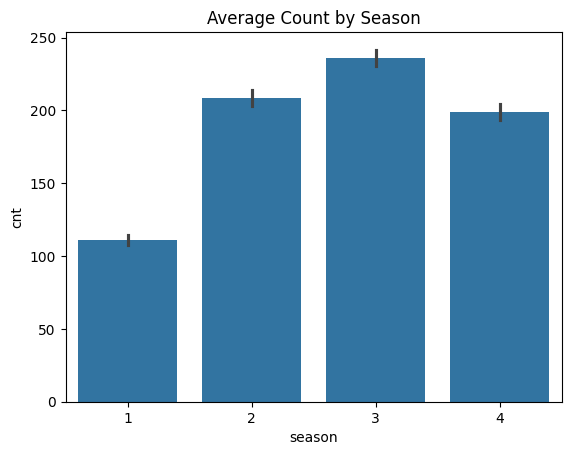

In [12]:
# Plot cnt vs season
sns.barplot(x='season', y='cnt', data=df, estimator='mean')
plt.title("Average Count by Season")
plt.show()

As expected, bike usage peaks in summer, season 3, and is lowest in winter, season 1. This matches logical expectations of seasonal patterns in bike share usage due to weather.

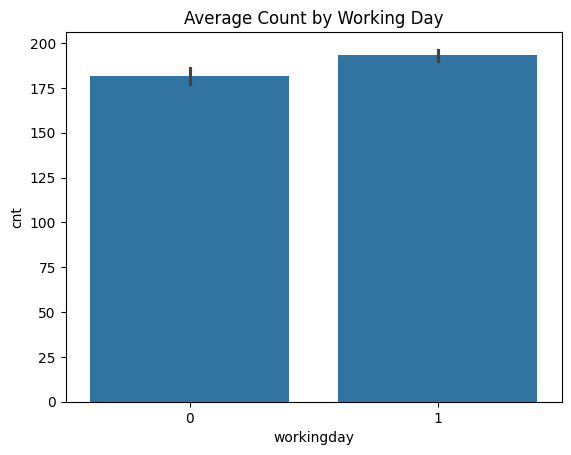

In [13]:
# cnt vs workingday
sns.barplot(x='workingday', y='cnt', data=df, estimator='mean')
plt.title("Average Count by Working Day")
plt.show()

- The bar plot shows a slightly higher average count of bike usage on working days, when workingday = 1.
- This suggests that bike sharing is slightly more popular on weekdays, potentially due to commuters using it as part of their regular workday travel.
- However, the difference is modest, indicating that weekend leisure use also makes a significant contribution.

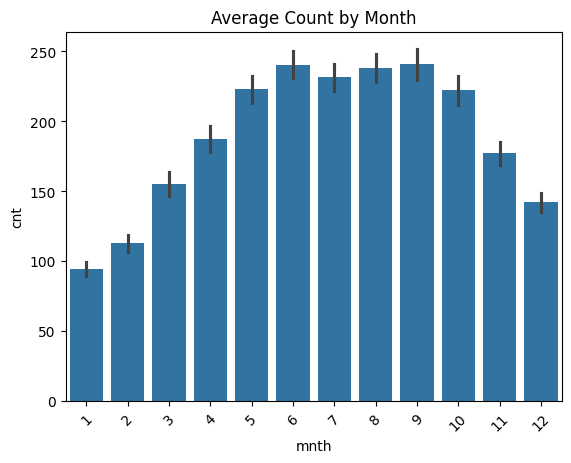

In [14]:
# cnt vs mnth
sns.barplot(x='mnth', y='cnt', data=df, estimator='mean')
plt.title("Average Count by Month")
plt.xticks(rotation=45)
plt.show()

- Usage increases from early spring (March) and peaks around June–September, dropping again in winter.
- This mirrors seasonal trends.

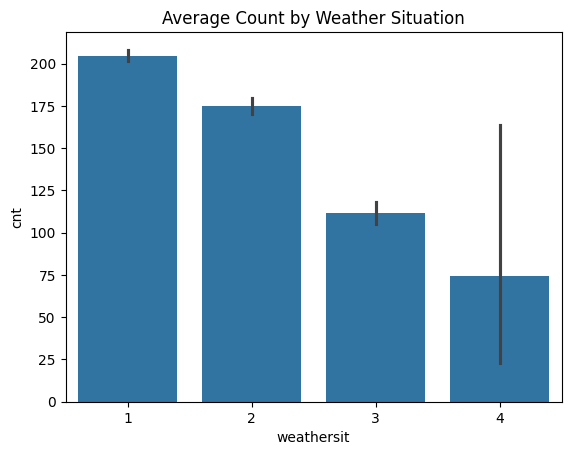

In [15]:
# cnt vs weathersit
sns.barplot(x='weathersit', y='cnt', data=df, estimator='mean')
plt.title("Average Count by Weather Situation")
plt.show()

As expected, ridership is highest under clear skies, weathersit = 1, and significantly lower during rain or snow, weathersit = 3.

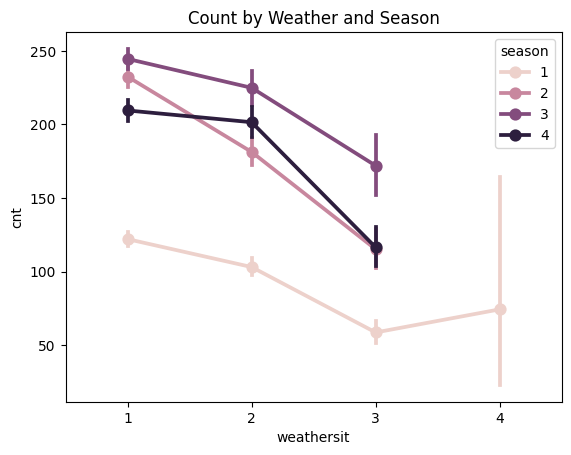

In [16]:
# cnt by weathersit and season
sns.pointplot(x='weathersit', y='cnt', hue='season', data=df)
plt.title("Count by Weather and Season")
plt.show()

Bad weather, weathersit = 3, reduces ridership across all seasons, but its effect is most pronounced in winter and least in summer, indicating that even light weather disruptions can severely impact winter ridership.

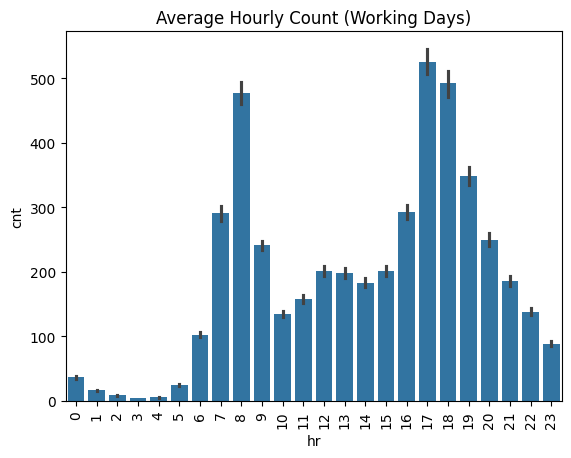

In [17]:
# cnt vs hr for workingday = 1
sns.barplot(x='hr', y='cnt', data=df[df['workingday'] == 1], estimator='mean')
plt.title("Average Hourly Count (Working Days)")
plt.xticks(rotation=90)
plt.show()


Clear morning peak around 8 AM and another around 5-6 PM, reflecting commuter patterns.

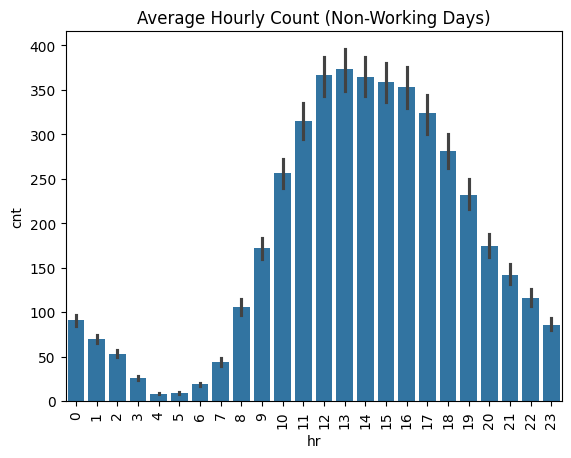

In [18]:
# cnt vs hr for workingday = 0
sns.barplot(x='hr', y='cnt', data=df[df['workingday'] == 0], estimator='mean')
plt.title("Average Hourly Count (Non-Working Days)")
plt.xticks(rotation=90)
plt.show()

Peak usage shifts to late morning and early afternoon (10 AM – 4 PM) on weekends, reflecting leisure activity.

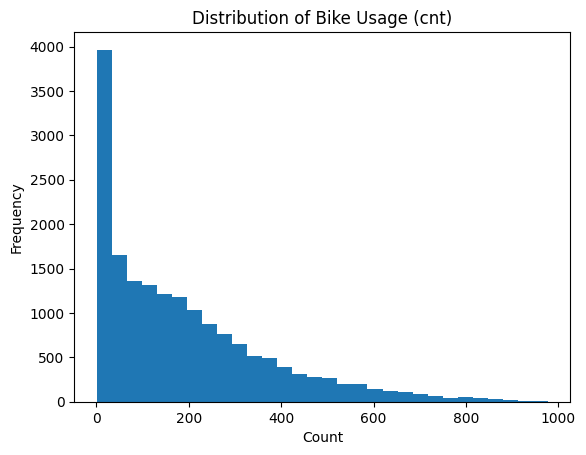

In [19]:
# Histogram of cnt
plt.hist(df['cnt'], bins=30)
plt.title("Distribution of Bike Usage (cnt)")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

- The distribution is right-skewed (positively skewed) with most hourly cnt values are concentrated at the low end (i.e., many hours have few bike rentals).
- A long tail extends toward higher cnt values, indicating that large spikes in hourly usage do occur, but are relatively rare.
- The peak frequency appears to be in the lowest bins — suggesting most hours have low to moderate ridership.

#### Part Two:

            season    yr  mnth    hr  ...  windspeed  casual  registered   cnt
season        1.00 -0.01  0.83 -0.01  ...      -0.15    0.12        0.17  0.18
yr           -0.01  1.00 -0.01 -0.00  ...      -0.01    0.14        0.25  0.25
mnth          0.83 -0.01  1.00 -0.01  ...      -0.14    0.07        0.12  0.12
hr           -0.01 -0.00 -0.01  1.00  ...       0.14    0.30        0.37  0.39
holiday      -0.01  0.01  0.02  0.00  ...       0.00    0.03       -0.05 -0.03
weekday      -0.00 -0.00  0.01 -0.00  ...       0.01    0.03        0.02  0.03
workingday    0.01 -0.00 -0.00  0.00  ...      -0.01   -0.30        0.13  0.03
weathersit   -0.01 -0.02  0.01 -0.02  ...       0.03   -0.15       -0.12 -0.14
temp          0.31  0.04  0.20  0.14  ...      -0.02    0.46        0.34  0.40
atemp         0.32  0.04  0.21  0.13  ...      -0.06    0.45        0.33  0.40
hum           0.15 -0.08  0.16 -0.28  ...      -0.29   -0.35       -0.27 -0.32
windspeed    -0.15 -0.01 -0.14  0.14  ...       1.00

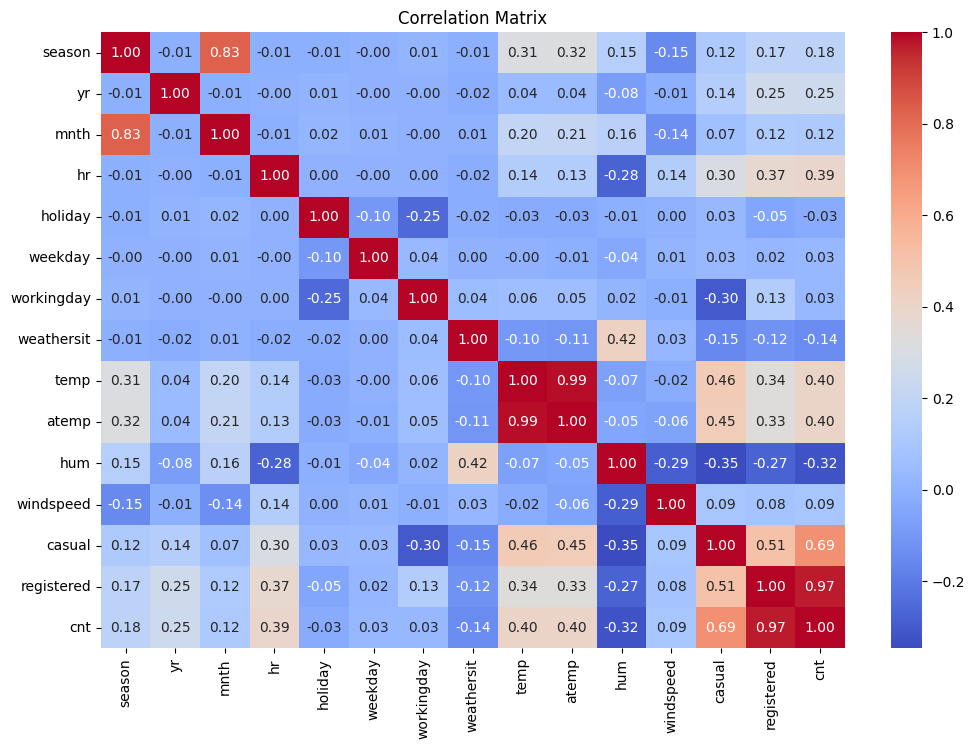

In [20]:
# Correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Display rounded correlation matrix for readability
corr_matrix_rounded = corr_matrix.round(2)
print(corr_matrix_rounded)

# Optional: Visualize with heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

##### Highly Correlated Pairs:
1. registered and cnt: ~0.97
- Extremely high correlation. Since cnt = casual + registered, this is expected. Registered users dominate overall bike usage.
2. casual and cnt: ~0.69
- Strong correlation, but lower than that of registered users. Suggests registered users are more consistent in behavior.
3. temp and atemp: ~0.99
- Almost perfect correlation. atemp (feels-like temperature) and temp (actual temperature) are essentially redundant. Keeping both would introduce multicollinearity.

In [21]:
# Drop the correlated / derived features
df.drop(columns=['casual', 'registered', 'atemp'], inplace=True)

# Sanity check
print("Remaining columns:", df.columns.tolist())
print("DataFrame shape:", df.shape)

Remaining columns: ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'cnt']
DataFrame shape: (17379, 12)


In [22]:
# Separate features and target
X = df.drop(columns='cnt')
y = df['cnt']

# Split into train and test sets with 33% test size) and fixed random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# Check the split
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 11643
Testing samples: 5736


#### Part Three:

In [23]:
# Define the model
lr = LinearRegression()

# Define scoring metrics
scoring = ['r2', 'neg_root_mean_squared_error']

# Perform cross-validation
cv_results = cross_validate(lr, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)

# Extract and convert negative RMSE to positive
rmse_scores = -cv_results['test_neg_root_mean_squared_error']
r2_scores = cv_results['test_r2']

In [24]:
# Report average R^2 and RMSE
print(f"Average R^2 Score (5-fold): {r2_scores.mean():.4f}")
print(f"Average RMSE (5-fold): {rmse_scores.mean():.2f}")

Average R^2 Score (5-fold): 0.3844
Average RMSE (5-fold): 143.28


- The R^2 Score of 0.3844 means that the baseline linear regression model explains ~38% of the variance in hourly bike usage (cnt).
- This is a modest fit, as expected for a model that does not yet encode categorical features, which linear regression cannot inherently interpret well.
- The RMSE of 143.28 indicates that, on average, predictions are off by about 143 bike rentals per hour. Considering the range of values in cnt, this is a considerable error.

#### Part Four:

In [25]:
# One-Hot encoding of categorical features
categorical_features = ['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'yr']

column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X_train_encoded = column_transformer.fit_transform(X_train)
X_test_encoded = column_transformer.transform(X_test)

print("X_train_encoded.shape[1]:", X_train_encoded.shape[1])
print("X_test_encoded.shape[1]:", X_test_encoded.shape[1])


X_train_encoded.shape[1]: 52
X_test_encoded.shape[1]: 52


In [26]:
# Linear Regression with encoded data
cv_results_lr = cross_validate(
    LinearRegression(),
    X_train_encoded,
    y_train,
    cv=5,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False
)

print("X_train_encoded shape:", X_train_encoded.shape)

X_train_encoded shape: (11643, 52)


In [27]:
# Calculate average scores
avg_r2_encoded = np.mean(cv_results_lr['test_r2'])
avg_rmse_encoded = -np.mean(cv_results_lr['test_neg_root_mean_squared_error'])

# Print results
print(f"Average R^2 Score (5-fold): {avg_r2_encoded:.4f}")
print(f"Average RMSE (5-fold): {avg_rmse_encoded:.2f}")

Average R^2 Score (5-fold): 0.6854
Average RMSE (5-fold): 102.41


- Compared to the unencoded baseline (R^2 = 0.3844, RMSE = 143.28), the model's performance improved significantly after encoding the categorical features.
- R^2 improved from 0.3844 to 0.6854 -> indicating the model now explains ~68.5% of the variance in bike usage (cnt).
- RMSE decreased from 143.28 → 102.41 -> showing reduced prediction error.

In [28]:
# Instantiate DT model
dt_model = DecisionTreeRegressor(random_state=0)

# Cross-validation with 5 folds and both metrics
dt_scores = cross_validate(
    dt_model,
    X_train_encoded,
    y_train,
    cv=5,
    scoring=('r2', 'neg_root_mean_squared_error'),
    return_train_score=False
)

# Extract and display average scores
dt_r2 = dt_scores['test_r2'].mean()
dt_rmse = -dt_scores['test_neg_root_mean_squared_error'].mean()

print(f"Decision Tree - Average R^2 Score (5-fold): {dt_r2:.4f}")
print(f"Decision Tree - Average RMSE (5-fold): {dt_rmse:.2f}")

Decision Tree - Average R^2 Score (5-fold): 0.8041
Decision Tree - Average RMSE (5-fold): 80.83


In [29]:
# Instantiate RF model
rf_model = RandomForestRegressor(random_state=0)

# Cross-validation with 5 folds and both metrics
rf_scores = cross_validate(
    rf_model,
    X_train_encoded,
    y_train,
    cv=5,
    scoring=('r2', 'neg_root_mean_squared_error'),
    return_train_score=False
)

# Extract and display average scores
rf_r2 = rf_scores['test_r2'].mean()
rf_rmse = -rf_scores['test_neg_root_mean_squared_error'].mean()

print(f"Random Forest - Average R^2 Score (5-fold): {rf_r2:.4f}")
print(f"Random Forest - Average RMSE (5-fold): {rf_rmse:.2f}")


Random Forest - Average R^2 Score (5-fold): 0.9023
Random Forest - Average RMSE (5-fold): 57.08


In [30]:
# Define the models to compare
models = {
    'Linear Regression (Unencoded)': LinearRegression(),
    'Linear Regression (Encoded)': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=0),
    'Random Forest Regressor': RandomForestRegressor(random_state=0)
}

# Dictionary to store the results
results = {}

# Loop through each model
for name, model in models.items():
    # Determine which feature set to use
    if "Unencoded" in name:
        X = X_train  # unencoded data
    else:
        X = X_train_encoded  # encoded data
    
    # Run cross-validation
    cv_results = cross_validate(
        model,
        X,
        y_train,
        cv=5,
        scoring=["r2", "neg_root_mean_squared_error"],
        return_train_score=False
    )
    
    # Calculate mean R² and RMSE (convert neg RMSE to positive)
    mean_r2 = cv_results['test_r2'].mean()
    mean_rmse = -cv_results['test_neg_root_mean_squared_error'].mean()
    
    # Save results
    results[name] = {
        'Avg R^2 Score': mean_r2,
        'Avg RMSE': mean_rmse
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})

# Display the results table
results_df


,Model,Avg R^2 Score,Avg RMSE
0,Linear Regression (Unencoded),0.384375,143.276741
1,Linear Regression (Encoded),0.685405,102.405919
2,Decision Tree Regressor,0.804105,80.829812
3,Random Forest Regressor,0.902268,57.076322


#### Part Five:

In [31]:
# Hyperparameter distributions
param_distributions = {
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [50, 100, 150, 200, 250]
}

# Initialize model
rf = RandomForestRegressor(random_state=0)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=0,
    n_jobs=-1
)

# Fit search on encoded training data
random_search.fit(X_train_encoded, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40],
                                        'max_features': [0.1, 0.2, 0.3, 0.4,
                                                         0.5, 0.6, 0.7, 0.8,
                                                         0.9, 1.0],
                                        'n_estimators': [50, 100, 150, 200,
                                                         250]},
                   random_state=0, scoring='neg_root_mean_squared_error')

In [32]:
# Get best hyperparameters
best_params = random_search.best_params_
best_rmse = -random_search.best_score_  # Convert to positive

print("Best Hyperparameters:")
print(best_params)
print(f"Best RMSE (5-fold CV): {best_rmse:.2f}")

Best Hyperparameters:
{'n_estimators': 200, 'max_features': 1.0, 'max_depth': 35}
Best RMSE (5-fold CV): 56.98


- The optimized model (`RMSE = 56.98`) slightly improves over the default Random Forest (`RMSE = 57.08`).
- Best settings involve: A relatively deep tree (`max_depth=35`), a large number of trees (`n_estimators=200`), and allowing 90% of features at each split (`max_features=1.0`).

In [33]:
# Predict on test set
y_pred = random_search.best_estimator_.predict(X_test_encoded)

# Compute R² and RMSE
r2_test = r2_score(y_test, y_pred)
rmse_test = sqrt(mean_squared_error(y_test, y_pred))

print(f"Test R^2 Score: {r2_test:.4f}")
print(f"Test RMSE: {rmse_test:.2f}")

Test R^2 Score: 0.9120
Test RMSE: 53.00


- The tuned Random Forest model outperformed the default version
- R^2 improved from 0.9022 to 0.9120
- RMSE reduced from 56.98 to 53.00

##### Conclusion: The RandomizedSearchCV was successful — tuning the model resulted in lower error and higher explanatory power, meaning it predicts bike share counts much more accurately.

## Note:
### This work has been assisted by GenAI models for the purpose of code debugging, validation, and enhancment. All GenAI assisted output was evaluated, verified, and adopted by author as needed to maintain academic ethical standards of conduct.

# End.